In [1]:
from tensorflow.keras.datasets import mnist

In [11]:
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential,Model
from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
(X_train,_),(_,_)=mnist.load_data()

In [4]:
print(X_train.shape)

(60000, 28, 28)


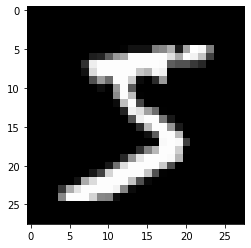

In [5]:
plt.imshow(X_train[0],cmap="gray")

Normalize

In [6]:
X_train=(X_train.astype('float32')-127.5)/127.5#median of 0-255 
print(np.min(X_train))
print(np.max(X_train))

-1.0
1.0


In [7]:
print(X_train.shape)

(60000, 28, 28)


In [8]:
total_epochs=50
batch_size=256 #(hOw many images i am going to pass through the discriminator in each batch )
no_of_batches=int(X_train.shape[0]/batch_size)   #(in one 1 epoch how many batches of data will pass hrough)#60000/256

half_batch=128 #128 fake, 128 real to pass through discriminator seperately
noise_dim=100#upsample into 784 Dim vector
adam=Adam(lr=2e-4,beta_1=0.5)

In [9]:
#Generatore
#Input noise((100 dim) outputs a vector 784 dim)

In [13]:
generator=Sequential()
generator.add(Dense(256,input_shape=(noise_dim,)))
generator.add(LeakyReLU(0.2)) #study about it.
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784,activation="tanh"))

generator.compile(loss="binary_crossentropy",optimizer=adam)
generator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 784)              

In [16]:
#DownSampling to 1.
discriminator=Sequential()
discriminator.add(Dense(512,input_shape=(784,)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(1,activation="sigmoid")) #classificationt
discriminator.compile(loss="binary_crossentropy",optimizer=adam)

discriminator.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


In [19]:
#GAN, step-->2

In [21]:
discriminator.trainable=False
gan_input=Input(shape=(noise_dim,))
generated_img=generator(gan_input)
gan_output=discriminator(generated_img)

#FUNCTIONAL API
model=Model(gan_input,gan_output)
model.compile(loss="binary_crossentropy",optimizer=adam)

In [ ]:
#Training loop
for epoch in range(total_epochs):
    epoch_d_loss=0
    epoch_g_loss=0
    
    #mini batch SGD
    
    for step in range(no_of_batches):
        
        #step-1 Discriminator
        #50%real data X
        
        idx=np.random.randint(0,X_train.shape[0],half_batch)
        real_imgs=X_train[idx]
        #fake data X
        #normal distribution
        noise = np.random.normal(0,1,size=(half_batch,noise_dim))
        fake_imgs=generator.predict(noise)#forward propogation
        
        #labels
        real_y=np.ones((half_batch,1))*0.9 #one side label smoothing for discriminator
        fake_y=np.zeros((half_batch,1))
        
        #Train our discriminator
        d_loss_real=discriminator.train_on_batch(real_imgs,real_y)
        d_loss_fake=discriminator.train_on_batch(fake_imgs,fake_y)
        
        d_loss=0.5*d_loss_real+0.5*d_loss_fake #total loss
        
        epoch_d_loss+=d_loss
        
        #Train generator(considering frozen disriminator)
        noise=np.random.normal(0,)